In [1]:
from pycbc.inference import io, models

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig_width_pt = 3*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]

params = { 'axes.labelsize': 24,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 24,
          'legend.fontsize': 20,
          'xtick.labelsize': 24,
          'ytick.labelsize': 24,
          'axes.grid' : True,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
          'figure.figsize': fig_size}

mpl.rcParams.update(params)

In [3]:
# load the posterior file
fp = io.loadfile('./result.hdf', 'r')
# get the config, the data, and PSDs from the file
# the config file:
cp = fp.read_config_file()
# the data
data = fp.read_data()
# the psds
psds = fp.read_psds()

In [4]:
# now let's load the model
model = models.read_from_config(cp, data=data, psds=psds)

In [5]:
# let's get the maximum likelihood point
samples = fp.read_samples(list(fp['samples'].keys()))
maxlidx = samples['loglikelihood'].argmax()
maxlparams = {p: samples[p][maxlidx] for p in model.variable_params}

In [6]:
# get the loglikelihood of these points
model.update(**maxlparams)
model.loglikelihood

-378277.2658737879

In [7]:
# get the matched-filter SNR
print((2*model.loglr)**0.5)

13.222354777011137


In [8]:
# get the gated, whitened maxL waveform and plot it against
# the whitened data
gated_wfs = model.get_gated_waveforms()
gated_data = model.get_gated_data()
# whiten them
gated_wfs = model.whiten(gated_wfs, 1)
gated_data = model.whiten(gated_data, 1)
# convert to the time domain
gated_wfs = {ifo: d.to_timeseries() for ifo, d in gated_wfs.items()}
gated_data = {ifo: d.to_timeseries() for ifo, d in gated_data.items()}

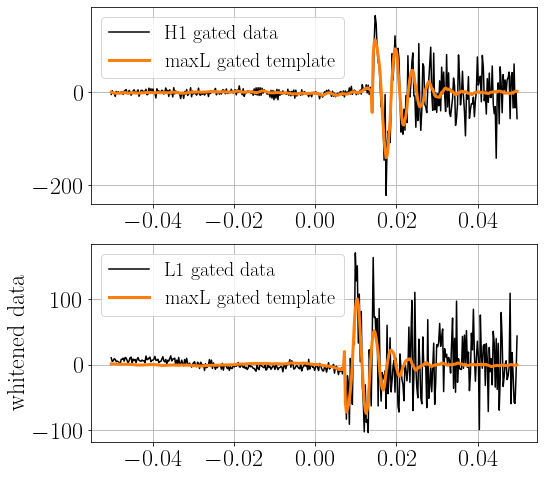

In [9]:
fig, axes = plt.subplots(nrows=2, figsize=(8,8))
for ii, ifo in enumerate(gated_wfs):
    ax = axes[ii]
    # we'll plot w.r.t. the geocentric end gate time
    t_gate_end = model.current_params['t_gate_end']
    d = gated_data[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='black', label='{} gated data'.format(ifo))
    # plot the waveform
    d = gated_wfs[ifo].time_slice(t_gate_end-0.05, t_gate_end+0.05)
    t = d.sample_times - t_gate_end
    ax.plot(t, d, color='C1', lw=3, label='maxL gated template')
    ax.legend()
    if ii == 2:
        ax.set_xlabel(r'time - $t_{\rm{gate\,end}}$ (s)')
    if ii == 1:
        ax.set_ylabel('whitened data')
fig.show()

In [10]:
gated_wfs = model.get_gated_waveforms()

In [11]:
gated_wfs

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f6add817b00>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f6add8175c0>}

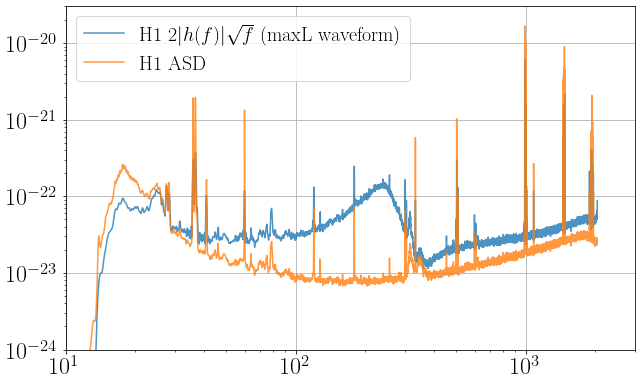

In [12]:
for ifo in ['H1']:
    f = gated_wfs[ifo].sample_frequencies
    plt.loglog(f,2*abs(gated_wfs[ifo])*np.sqrt(f),alpha=0.8,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
    plt.loglog(psds[ifo].sample_frequencies,np.sqrt(psds[ifo]),alpha=0.8,label=str(ifo)+' ASD')
    plt.xlim(10,3000)
    plt.ylim(1e-24,3e-20)
    plt.legend()

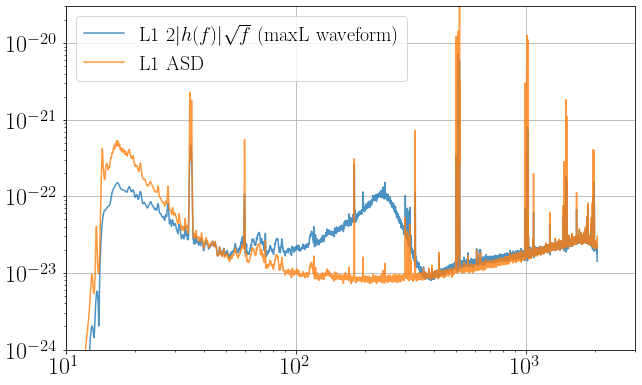

In [13]:
for ifo in ['L1']:
    f = gated_wfs[ifo].sample_frequencies
    plt.loglog(f,2*abs(gated_wfs[ifo])*np.sqrt(f),alpha=0.8,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
    plt.loglog(psds[ifo].sample_frequencies,np.sqrt(psds[ifo]),alpha=0.8,label=str(ifo)+' ASD')
    plt.xlim(10,3000)
    plt.ylim(1e-24,3e-20)
    plt.legend()

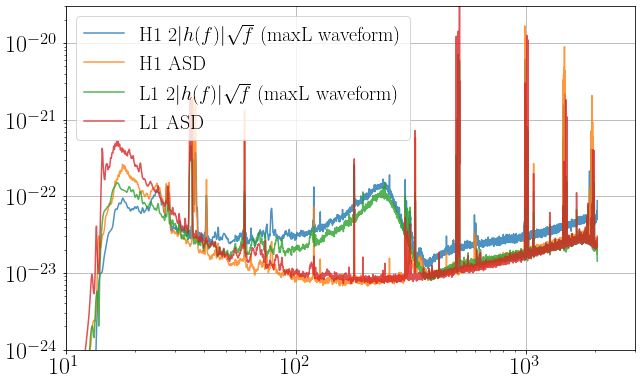

In [14]:
for ifo in ['H1','L1']:
    f = gated_wfs[ifo].sample_frequencies
    plt.loglog(f,2*abs(gated_wfs[ifo])*np.sqrt(f),alpha=0.8,label=str(ifo)+' $2|h(f)|\sqrt{f}$ (maxL waveform)')
    plt.loglog(psds[ifo].sample_frequencies,np.sqrt(psds[ifo]),alpha=0.8,label=str(ifo)+' ASD')
    plt.xlim(10,3000)
    plt.ylim(1e-24,3e-20)
    plt.legend()

In [15]:
model.current_params

{'final_mass': 75.62427016840928,
 'final_spin': 0.7688638711644948,
 'amp220': 6.1316071521391845e-21,
 'phi220': 3.956039214027367,
 'absamp221': 9.911798607156752e-21,
 'phi221': 0.5023795835899509,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265,
 't_gate_start': 1126259460.4083147,
 't_gate_end': 1126259462.4083147,
 'tc': 1126259462.4073148,
 'amp221': 1.6165090752265074}

In [16]:
model.static_params

{'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265}

In [17]:
from pycbc.inference.models.gaussian_noise import create_waveform_generator

In [18]:
static_p = model.static_params
static_p['apprxoimant'] = 'FdQNMfromFinalMassSpin'

In [19]:
waveform_generator = create_waveform_generator(
            model.variable_params, model.data,
            waveform_transforms=model.waveform_transforms,
            recalibration=model.recalibration,
            gates=model.gates, **static_p)

In [21]:
maxlparams

{'final_mass': 75.62427016840928,
 'final_spin': 0.7688638711644948,
 'amp220': 6.1316071521391845e-21,
 'phi220': 3.956039214027367,
 'absamp221': 9.911798607156752e-21,
 'phi221': 0.5023795835899509}

In [22]:
model.current_params

{'final_mass': 75.62427016840928,
 'final_spin': 0.7688638711644948,
 'amp220': 6.1316071521391845e-21,
 'phi220': 3.956039214027367,
 'absamp221': 9.911798607156752e-21,
 'phi221': 0.5023795835899509,
 'approximant': 'TdQNMfromFinalMassSpin',
 'harmonics': 'spheroidal',
 'tref': 1126259462.4083147,
 'ra': 1.95,
 'dec': -1.27,
 'toffset': 0.0,
 'lmns': 222.0,
 'polarization': 0.82,
 'inclination': 3.14159265,
 't_gate_start': 1126259460.4083147,
 't_gate_end': 1126259462.4083147,
 'tc': 1126259462.4073148,
 'amp221': 1.6165090752265074}

In [23]:
wf = waveform_generator.generate(**model.current_params)

In [25]:
wf_from_pycbc = model.get_waveforms()

In [26]:
wf_from_pycbc

{'H1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f6aad136e80>,
 'L1': <pycbc.types.frequencyseries.FrequencySeries at 0x7f6ab454ae10>}

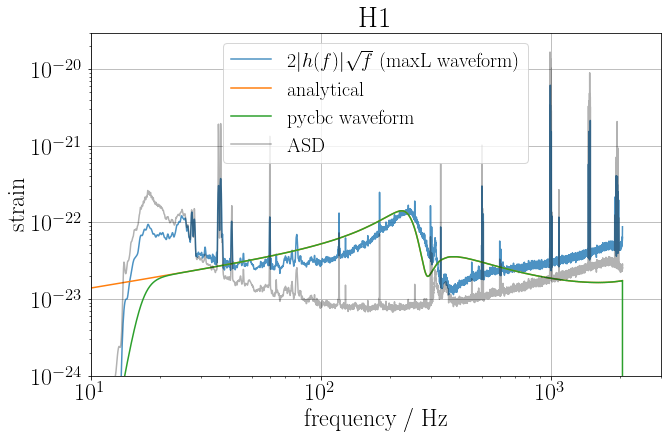

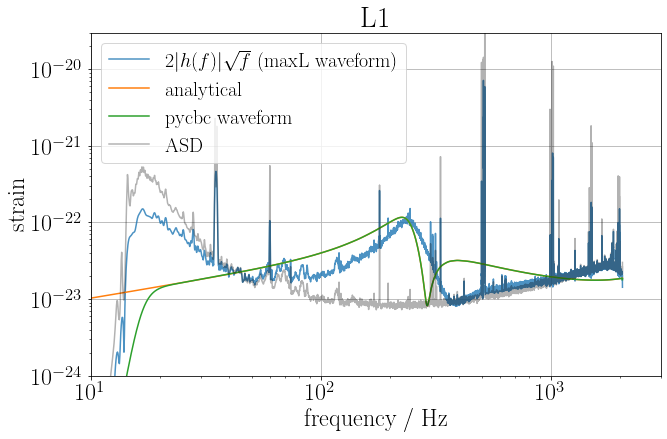

In [31]:
for ifo in ['H1','L1']:
    f = gated_wfs[ifo].sample_frequencies
    f_ana = wf[ifo].sample_frequencies
    f_pycbc = wf_from_pycbc[ifo].sample_frequencies
    plt.figure()
    plt.loglog(f,2*abs(gated_wfs[ifo])*np.sqrt(f),alpha=0.8,label='$2|h(f)|\sqrt{f}$ (maxL waveform)')
    plt.loglog(f_ana,2*abs(wf[ifo])*np.sqrt(f_ana),label='analytical')
    plt.loglog(f_pycbc,2*abs(wf_from_pycbc[ifo])*np.sqrt(f_pycbc),label='pycbc waveform')
    plt.loglog(psds[ifo].sample_frequencies,np.sqrt(psds[ifo]),c='k',alpha=0.3,label='ASD')
    plt.xlim(10,3000)
    plt.ylim(1e-24,3e-20)
    plt.title(str(ifo))
    plt.xlabel('frequency / Hz')
    plt.ylabel('strain')
    plt.legend()